## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Procedure

* Do a proof of concept for the software pipeline for this project by coding and applying to one image. 
* Once completed, see if the software pipeline is robust enough with other images
* If unsatisfactory, try tweaking the parameters
* If satisfactory, enable the code to allow video (From the 1st project)

## CALIBRATION

In [58]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# ym_per_pix = 30/700 # meters per pixel in y dimension
# xm_per_pix = 3.7/1200 # meters per pixel in x dimensio


objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Test whether undistortion works on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

## UNDISTORTION

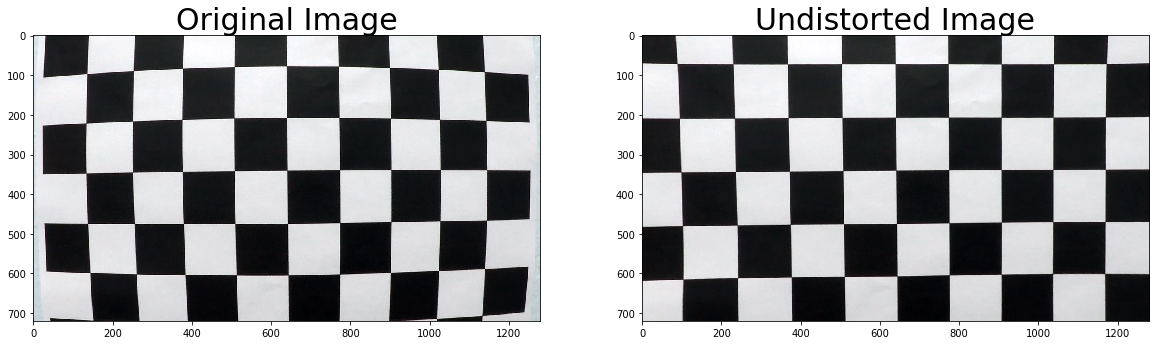

In [59]:
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save mtx and dist in a dict
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

f.savefig('output_images/undistort_output.png')


True

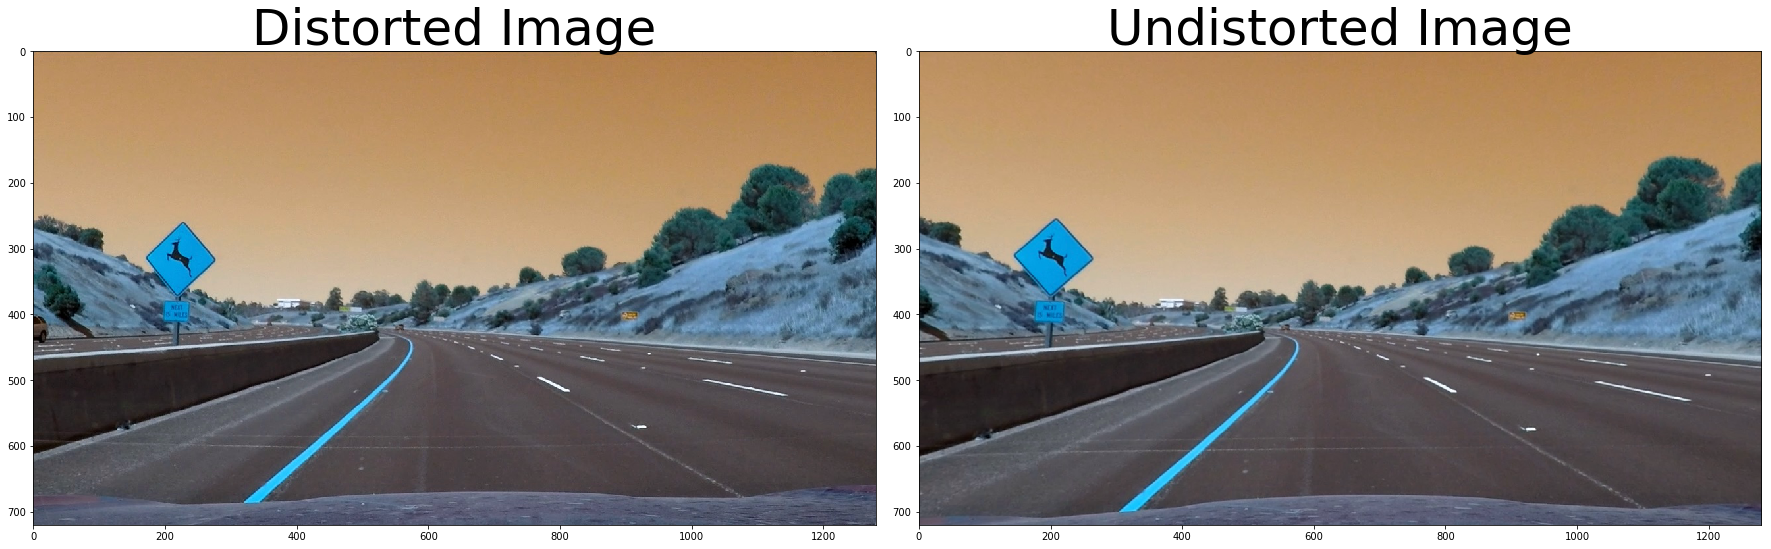

In [60]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test_images/test2.jpg')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image

def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Distorted Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('output_images/undistoretd_test1.jpg',undistorted)

## THRESHOLD BINARY IMAGE

True

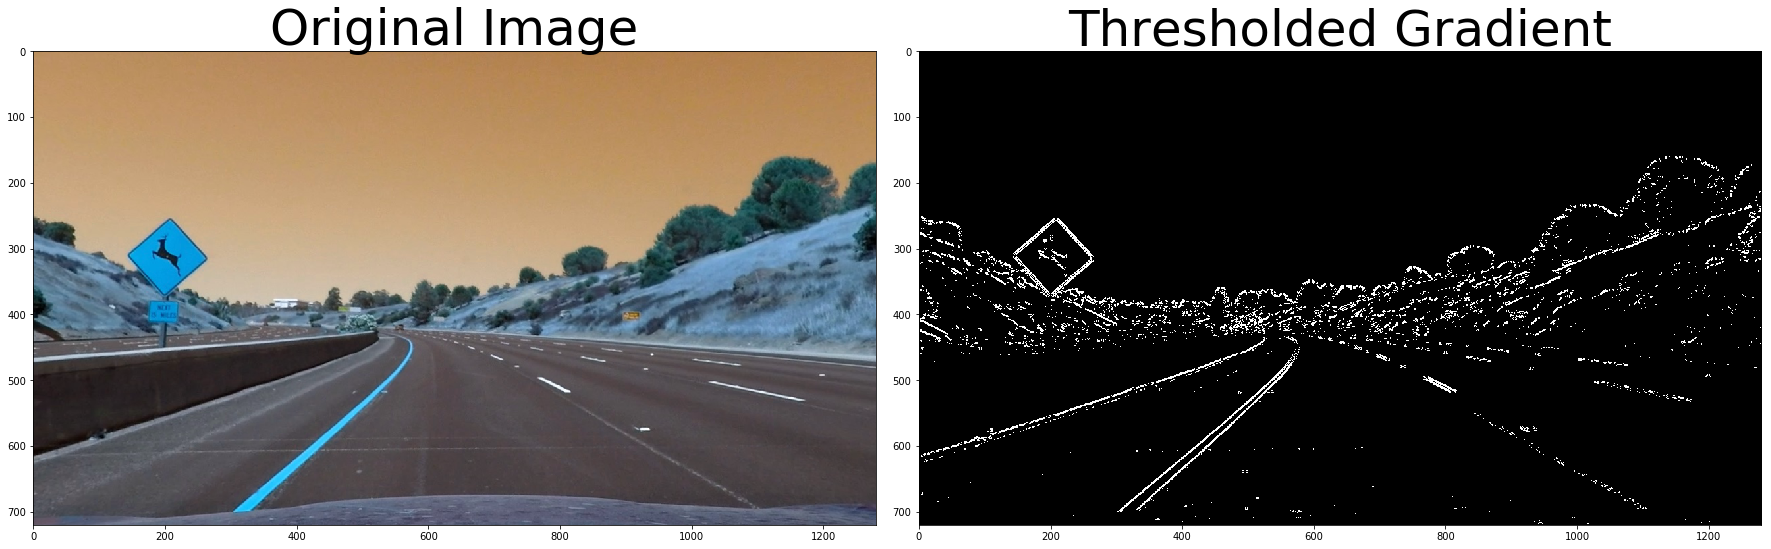

In [61]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx) 
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & ( absgraddir <= thresh[1])] = 1
    return binary_output

ksize = 3 

gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize,thresh=(20,100) )
grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(20,100) )
mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, mag_thresh=(50, 250))
dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

combined = combined*255

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('output_images/binary_comb.jpg',combined)

## PERSPECTIVE TRANSFORM

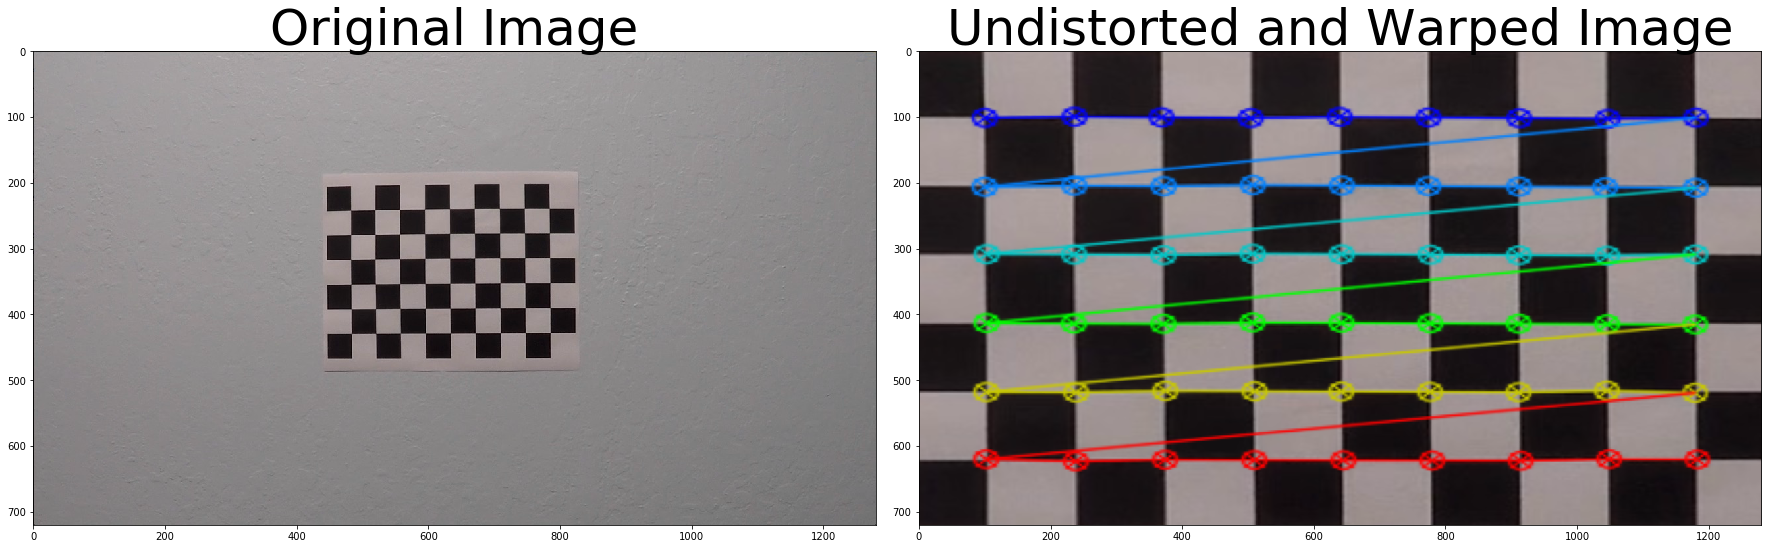

In [62]:
# Read in an image
img = cv2.imread('camera_cal/calibration6.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:

        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        img_size = (gray.shape[1], gray.shape[0])

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## LANE BOUNDARY

True

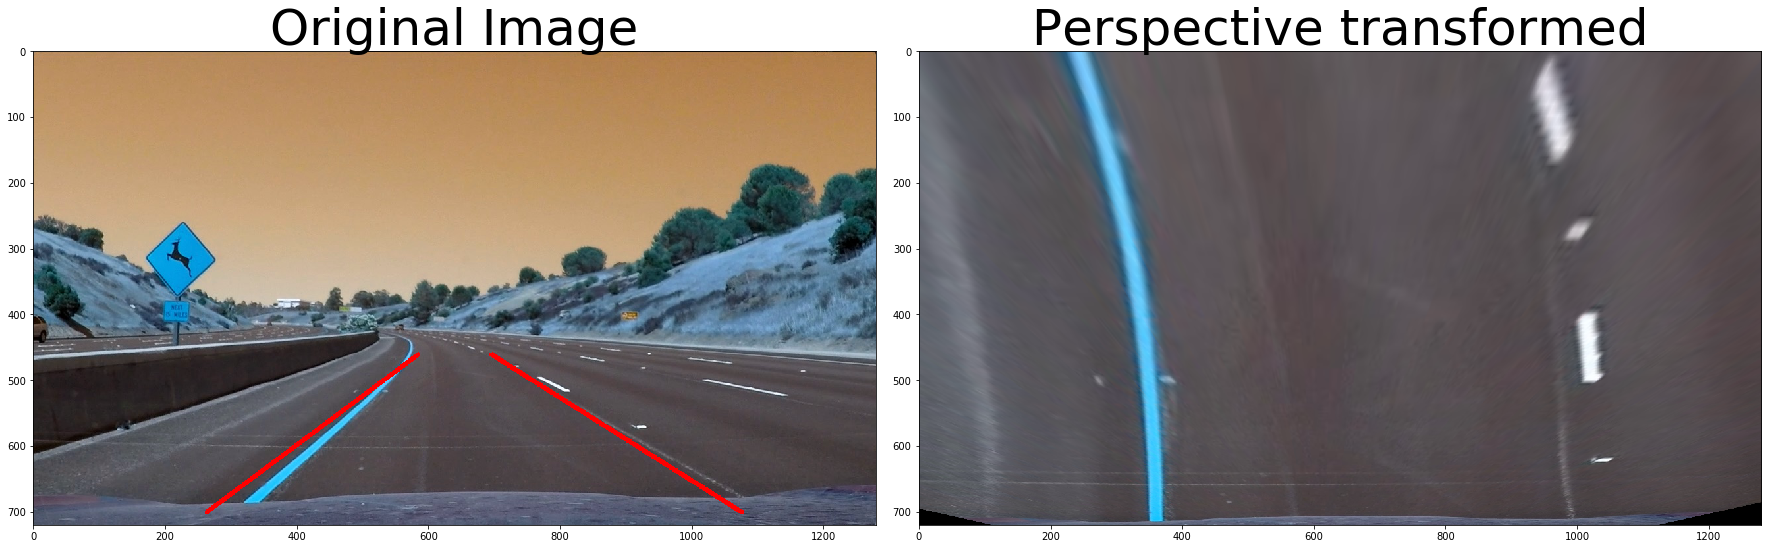

In [63]:

img = cv2.imread('test_images/test2.jpg')
img_size = (img.shape[1], img.shape[0])

src = np.float32(
[[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
[((img_size[0] / 6) + 50), img_size[1]-20],
[(img_size[0] * 5 / 6) + 10, img_size[1]-20],
[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

cv2.line(img, (src[0,0],src[0,1]), (src[1,0], src[1,1]), (255, 0, 0), thickness=5)
cv2.line(img, (src[2,0],src[2,1]), (src[3,0], src[3,1]), (255, 0, 0), thickness=5)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Perspective transformed', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('output_images/perspective_transformed.jpg',warped)

True

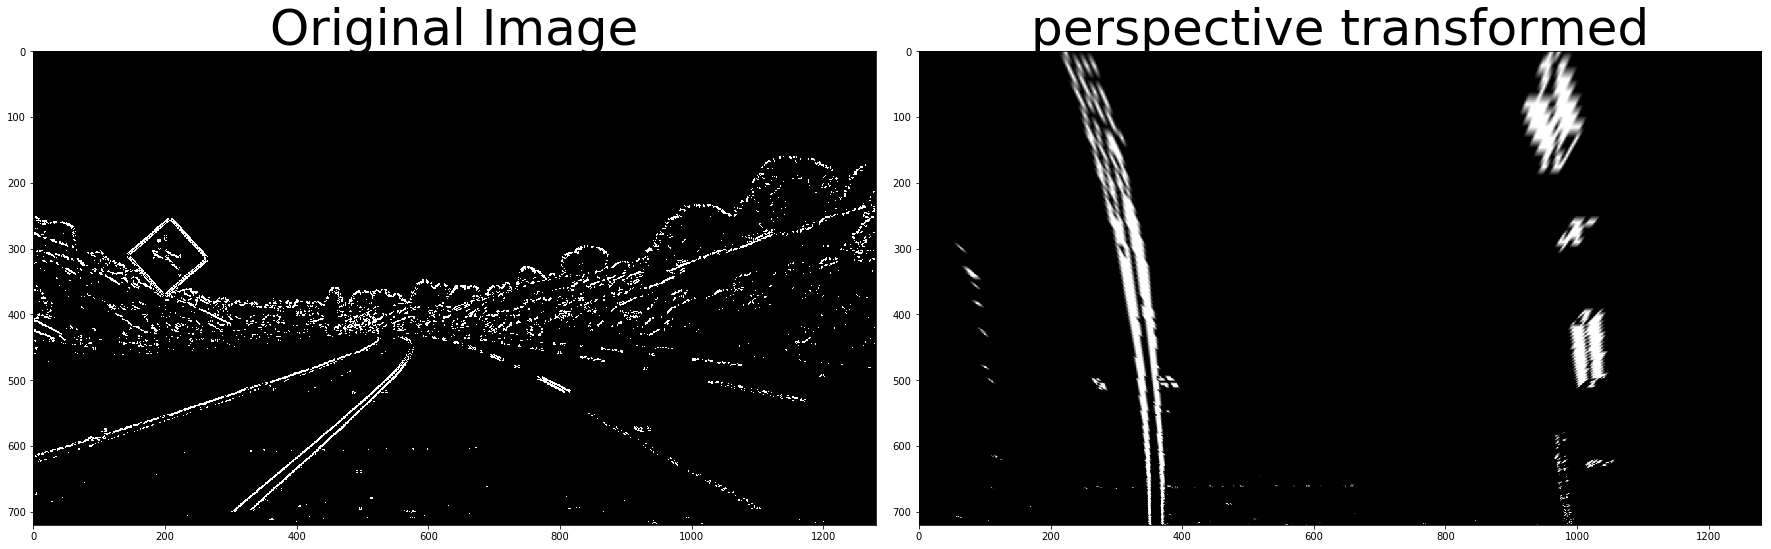

In [64]:
#After applying the thresholds
img = combined
img_size = (img.shape[1], img.shape[0])

src = np.float32(
[[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
[((img_size[0] / 6) + 50), img_size[1]-20],
[(img_size[0] * 5 / 6) + 10, img_size[1]-20],
[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped,cmap='gray')
ax2.set_title('perspective transformed', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('output_images/bit_transformed.jpg',warped)

True

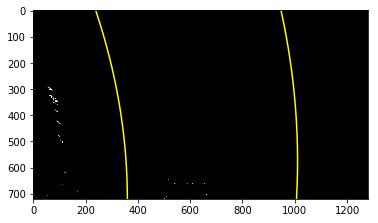

In [65]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    ym_per_pix = 30/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/1200 # meters per pixel in x dimension
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit

out_img,left_fit,right_fit = fit_polynomial(warped)

plt.imshow(out_img)
cv2.imwrite('output_images/window_output.jpg',out_img)


True

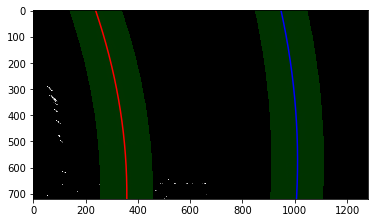

In [66]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    ym_per_pix = 30/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/1200 # meters per pixel in x dimension
 
    leftx1 = np.array(leftx)*xm_per_pix
    rightx1  = np.array(rightx)*xm_per_pix
    lefty1  = np.array(lefty)*ym_per_pix
    righty1  = np.array(righty)*ym_per_pix
    
    left_fit = np.polyfit(lefty1, leftx1, 2)
    right_fit = np.polyfit(righty1, rightx1, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fit1 = np.polyfit(lefty, leftx, 2)
    right_fit1 = np.polyfit(righty, rightx, 2)
    left_fitx = left_fit1[0]*ploty**2 + left_fit1[1]*ploty + left_fit1[2]
    right_fitx = right_fit1[0]*ploty**2 + right_fit1[1]*ploty + right_fit1[2]

    return left_fitx, right_fitx, ploty,left_fit,right_fit

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    # Fit new polynomials
    left_fitx, right_fitx, ploty,left_fit,right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='blue')
    ## End visualization steps ##
    
    return result,left_fitx, right_fitx, ploty,left_fit,right_fit

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,left_fitx, right_fitx, ploty,left_fit,right_fit = search_around_poly(warped,left_fit,right_fit)

# View your output
plt.imshow(result)
cv2.imwrite("output_images/color_fit_line.jpg", result)

## CURVATURE & POSITION

In [67]:

def measure_curvature_pixels(left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''  
    ym_per_pix = 30/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/1200 # meters per pixel in x dimension
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return int(left_curverad), int(right_curverad)


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(left_fit, right_fit)

print(left_curverad, right_curverad)


1232 1559


In [68]:
def find_offset(left_fit, right_fit):
    left_fitx = left_fit[0]*30**2 + left_fit[1]*30 + left_fit[2]
    right_fitx = right_fit[0]*30**2 + right_fit[1]*30 + right_fit[2]
    offset =  round(abs((left_fitx+right_fitx)/2 - 1.75),2)
    return offset
offset = find_offset(left_fit,right_fit)

True

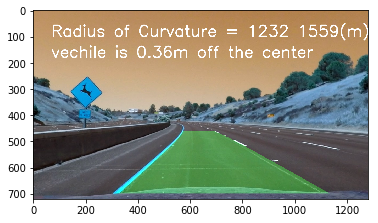

In [93]:
Minv = cv2.getPerspectiveTransform(dst, src)
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)


font = cv2.FONT_HERSHEY_SIMPLEX

text1 = "Radius of Curvature = "+ str(left_curverad) + " "+ str(right_curverad) + "(m)"
cv2.putText(result, text1, (70,100), font, 2, (255, 255, 255), 4, cv2.LINE_AA)
cv2.putText(result, 'vechile is '+ str(offset) + 'm off the center', (70, 180), font, 2, (255, 255, 255), 4, cv2.LINE_AA)
plt.imshow(result)
cv2.imwrite("output_images/comback.jpg", result)


## WARP LANE BOUNDARIES TO ORIGINAL IMAGE

In [94]:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.distance = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def isDetected():
        return self.detected

In [95]:
def sanity_check(left_curverad, right_curverad, left_fit, right_fit, offset):
    left_error  = np.sqrt(np.sum(abs(left_fit-left_line.current_fit)))
    right_error = np.sqrt(np.sum(abs(right_fit-right_line.current_fit)))

    if abs(offset-left_line.distance)>1:
        return False
  
    elif left_error > 100:
        return False
    elif right_error > 100:
        return False
    else:
        return True
    
def assign_line(left_fit, right_fit,left_fitx,right_fitx,left_curverad,right_curverad, offset):
    left_line.detected = True
    right_line.detected = True
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
    left_line.distance = offset
    right_line.distance = offset
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    left_line.allx = left_fitx 
    right_line.allx = right_fitx
    left_line.recent_xfitted.append(left_fitx) 
    right_line.recent_xfitted.append(right_fitx)

## Software pipeline


In [96]:
def process_image(image):
    print("---------------------------")
#     plt.imshow(image)
    undistorted = cal_undistort(image, mtx, dist)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize,thresh=(20,100) )
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(20,100) )
    mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.6, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    combined = combined*255
    
    img_size = (combined.shape[1], combined.shape[0])

    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) + 70), img_size[1]-20],
    [(img_size[0] * 5 / 6) + 30, img_size[1]-20],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    output_image,left_fit,right_fit = fit_polynomial(warped) ##

    result,left_fitx, right_fitx, ploty,left_fit,right_fit = search_around_poly(warped,left_fit,right_fit)
    
    left_curverad, right_curverad = measure_curvature_pixels(left_fit, right_fit)
    offset = find_offset(left_fit,right_fit)
    #assign_line(left_fit, right_fit,left_fitx,right_fitx,left_curverad,right_curverad, offset)
    
    Minv = cv2.getPerspectiveTransform(dst, src)

#     Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

#     Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

#     Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX

    text1 = "Radius of Curvature = "+ str(left_curverad) + " "+ str(right_curverad) + "(m)"
    cv2.putText(result, text1, (70,100), font, 2, (255, 255, 255), 4, cv2.LINE_AA)
    cv2.putText(result, 'vehicle is '+ str(offset) + 'm off the center', (70, 180), font, 2, (255, 255, 255), 4, cv2.LINE_AA)

    print(left_curverad, right_curverad, offset)
    
    return result

---------------------------
1222 1438 0.3


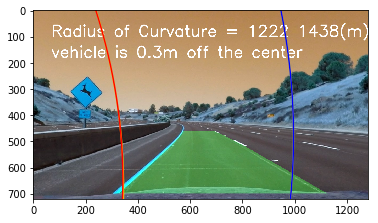

In [97]:
img = cv2.imread('test_images/test2.jpg')
result = process_image(img)
plt.imshow(result)

## Visualisation

---------------------------
1093 1509 0.32
[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4


  0%|          | 0/126 [00:00<?, ?it/s]

---------------------------


  1%|          | 1/126 [00:00<00:42,  2.97it/s]

1093 1509 0.32
---------------------------


  2%|▏         | 2/126 [00:00<00:40,  3.03it/s]

1035 2276 0.33
---------------------------


  2%|▏         | 3/126 [00:00<00:39,  3.11it/s]

1277 1081 0.32
---------------------------


  3%|▎         | 4/126 [00:01<00:38,  3.19it/s]

1275 906 0.33
---------------------------


  4%|▍         | 5/126 [00:01<00:37,  3.24it/s]

1297 1001 0.33
---------------------------


  5%|▍         | 6/126 [00:01<00:36,  3.26it/s]

1237 1561 0.34
---------------------------


  6%|▌         | 7/126 [00:02<00:36,  3.29it/s]

1246 1757 0.35
---------------------------


  6%|▋         | 8/126 [00:02<00:35,  3.29it/s]

1271 2803 0.4
---------------------------


  7%|▋         | 9/126 [00:02<00:35,  3.33it/s]

1233 2092 0.4
---------------------------


  8%|▊         | 10/126 [00:03<00:34,  3.34it/s]

1260 3127 0.38
---------------------------


  9%|▊         | 11/126 [00:03<00:34,  3.34it/s]

1303 1936 0.35
---------------------------


 10%|▉         | 12/126 [00:03<00:33,  3.37it/s]

1325 1747 0.34
---------------------------


 10%|█         | 13/126 [00:03<00:33,  3.37it/s]

1348 2570 0.35
---------------------------


 11%|█         | 14/126 [00:04<00:33,  3.36it/s]

1371 8988 0.35
---------------------------


 12%|█▏        | 15/126 [00:04<00:32,  3.39it/s]

1453 1429 0.33
---------------------------


 13%|█▎        | 16/126 [00:04<00:32,  3.39it/s]

1960 1111 0.33
---------------------------


 13%|█▎        | 17/126 [00:05<00:32,  3.40it/s]

2124 1576 0.33
---------------------------


 14%|█▍        | 18/126 [00:05<00:31,  3.39it/s]

1782 1856 0.33
---------------------------


 15%|█▌        | 19/126 [00:05<00:31,  3.39it/s]

1813 2827 0.33
---------------------------


 16%|█▌        | 20/126 [00:05<00:31,  3.38it/s]

2037 3246 0.33
---------------------------


 17%|█▋        | 21/126 [00:06<00:31,  3.38it/s]

1841 4715 0.36
---------------------------


 17%|█▋        | 22/126 [00:06<00:31,  3.35it/s]

1697 3754 0.35
---------------------------


 18%|█▊        | 23/126 [00:06<00:30,  3.36it/s]

1907 407935 0.33
---------------------------


 19%|█▉        | 24/126 [00:07<00:30,  3.37it/s]

1593 1278 0.29
---------------------------


 20%|█▉        | 25/126 [00:07<00:29,  3.40it/s]

1486 1317 0.29
---------------------------


 21%|██        | 26/126 [00:07<00:29,  3.39it/s]

1452 1691 0.29
---------------------------


 21%|██▏       | 27/126 [00:08<00:29,  3.39it/s]

1307 3588 0.3
---------------------------


 22%|██▏       | 28/126 [00:08<00:28,  3.38it/s]

1355 7871 0.3
---------------------------


 23%|██▎       | 29/126 [00:08<00:28,  3.40it/s]

1559 1688 0.29
---------------------------


 24%|██▍       | 30/126 [00:08<00:28,  3.37it/s]

1571 935 0.29
---------------------------


 25%|██▍       | 31/126 [00:09<00:28,  3.37it/s]

1290 1175 0.29
---------------------------


 25%|██▌       | 32/126 [00:09<00:27,  3.40it/s]

1035 1846 0.3
---------------------------


 26%|██▌       | 33/126 [00:09<00:27,  3.37it/s]

1177 3642 0.32
---------------------------


 27%|██▋       | 34/126 [00:10<00:27,  3.35it/s]

1100 4315 0.35
---------------------------


 28%|██▊       | 35/126 [00:10<00:27,  3.35it/s]

1044 1754 0.3
---------------------------


 29%|██▊       | 36/126 [00:10<00:26,  3.38it/s]

1000 968 0.28
---------------------------


 29%|██▉       | 37/126 [00:11<00:26,  3.40it/s]

897 1316 0.29
---------------------------


 30%|███       | 38/126 [00:11<00:25,  3.42it/s]

872 2670 0.31
---------------------------


 31%|███       | 39/126 [00:11<00:25,  3.44it/s]

812 888 0.28
---------------------------


 32%|███▏      | 40/126 [00:11<00:25,  3.42it/s]

834 840 0.28
---------------------------


 33%|███▎      | 41/126 [00:12<00:24,  3.41it/s]

827 909 0.29
---------------------------


 33%|███▎      | 42/126 [00:12<00:24,  3.42it/s]

908 884 0.3
---------------------------


 34%|███▍      | 43/126 [00:13<00:31,  2.65it/s]

969 1110 0.31
---------------------------


 35%|███▍      | 44/126 [00:13<00:30,  2.69it/s]

953 1182 0.31
---------------------------


 36%|███▌      | 45/126 [00:13<00:31,  2.60it/s]

991 1365 0.32
---------------------------


 37%|███▋      | 46/126 [00:14<00:30,  2.60it/s]

997 2643 0.33
---------------------------


 37%|███▋      | 47/126 [00:14<00:29,  2.69it/s]

1020 5863 0.34
---------------------------


 38%|███▊      | 48/126 [00:14<00:29,  2.66it/s]

973 1092 0.3
---------------------------


 39%|███▉      | 49/126 [00:15<00:28,  2.70it/s]

1015 1250 0.31
---------------------------


 40%|███▉      | 50/126 [00:15<00:28,  2.64it/s]

1095 979 0.3
---------------------------


 40%|████      | 51/126 [00:16<00:27,  2.70it/s]

1177 1618 0.32
---------------------------


 41%|████▏     | 52/126 [00:16<00:27,  2.66it/s]

1237 1469 0.31
---------------------------


 42%|████▏     | 53/126 [00:16<00:26,  2.72it/s]

1716 923 0.31
---------------------------


 43%|████▎     | 54/126 [00:17<00:26,  2.67it/s]

1623 871 0.3
---------------------------


 44%|████▎     | 55/126 [00:17<00:26,  2.68it/s]

1751 928 0.31
---------------------------


 44%|████▍     | 56/126 [00:17<00:26,  2.62it/s]

1848 1151 0.31
---------------------------


 45%|████▌     | 57/126 [00:18<00:25,  2.69it/s]

2010 1570 0.31
---------------------------


 46%|████▌     | 58/126 [00:18<00:25,  2.63it/s]

1765 2191 0.32
---------------------------


 47%|████▋     | 59/126 [00:19<00:25,  2.66it/s]

1614 2984 0.32
---------------------------


 48%|████▊     | 60/126 [00:19<00:25,  2.62it/s]

1476 1374 0.29
---------------------------


 48%|████▊     | 61/126 [00:19<00:24,  2.68it/s]

1426 2664 0.3
---------------------------


 49%|████▉     | 62/126 [00:20<00:24,  2.63it/s]

1319 1549 0.29
---------------------------


 50%|█████     | 63/126 [00:20<00:23,  2.68it/s]

1288 2018 0.28
---------------------------


 51%|█████     | 64/126 [00:20<00:23,  2.62it/s]

1243 1020 0.26
---------------------------


 52%|█████▏    | 65/126 [00:21<00:22,  2.68it/s]

1266 1149 0.27
---------------------------


 52%|█████▏    | 66/126 [00:21<00:22,  2.66it/s]

1135 1335 0.27
---------------------------


 53%|█████▎    | 67/126 [00:22<00:22,  2.59it/s]

1160 1551 0.27
---------------------------


 54%|█████▍    | 68/126 [00:22<00:21,  2.65it/s]

1438 1971 0.27
---------------------------


 55%|█████▍    | 69/126 [00:22<00:21,  2.62it/s]

1401 3264 0.27
---------------------------


 56%|█████▌    | 70/126 [00:23<00:21,  2.58it/s]

1491 7580 0.28
---------------------------


 56%|█████▋    | 71/126 [00:23<00:20,  2.65it/s]

1552 1643 0.26
---------------------------


 57%|█████▋    | 72/126 [00:24<00:21,  2.57it/s]

1640 1166 0.24
---------------------------


 58%|█████▊    | 73/126 [00:24<00:20,  2.62it/s]

1717 1256 0.24
---------------------------


 59%|█████▊    | 74/126 [00:24<00:20,  2.58it/s]

1868 1629 0.25
---------------------------


 60%|█████▉    | 75/126 [00:25<00:19,  2.63it/s]

2035 1738 0.25
---------------------------


 60%|██████    | 76/126 [00:25<00:19,  2.58it/s]

2467 1207 0.24
---------------------------


 61%|██████    | 77/126 [00:25<00:18,  2.64it/s]

3053 1453 0.24
---------------------------


 62%|██████▏   | 78/126 [00:26<00:18,  2.57it/s]

2964 1311 0.24
---------------------------


 63%|██████▎   | 79/126 [00:26<00:17,  2.61it/s]

3990 1037 0.24
---------------------------


 63%|██████▎   | 80/126 [00:27<00:17,  2.56it/s]

4744 933 0.24
---------------------------


 64%|██████▍   | 81/126 [00:27<00:17,  2.64it/s]

6211 1171 0.24
---------------------------


 65%|██████▌   | 82/126 [00:27<00:16,  2.60it/s]

4463 1335 0.23
---------------------------


 66%|██████▌   | 83/126 [00:28<00:16,  2.66it/s]

3297 2014 0.24
---------------------------


 67%|██████▋   | 84/126 [00:28<00:16,  2.62it/s]

3137 3822 0.25
---------------------------


 67%|██████▋   | 85/126 [00:28<00:15,  2.68it/s]

2545 9037 0.25
---------------------------


 68%|██████▊   | 86/126 [00:29<00:15,  2.62it/s]

2138 6552 0.26
---------------------------


 69%|██████▉   | 87/126 [00:29<00:14,  2.67it/s]

1570 1445 0.21
---------------------------


 70%|██████▉   | 88/126 [00:30<00:14,  2.63it/s]

1397 2611 0.23
---------------------------


 71%|███████   | 89/126 [00:30<00:16,  2.25it/s]

1296 1871 0.22
---------------------------


 71%|███████▏  | 90/126 [00:31<00:15,  2.27it/s]

1155 951 0.21
---------------------------


 72%|███████▏  | 91/126 [00:31<00:14,  2.37it/s]

1193 1004 0.21
---------------------------


 73%|███████▎  | 92/126 [00:31<00:14,  2.39it/s]

1161 1267 0.22
---------------------------


 74%|███████▍  | 93/126 [00:32<00:13,  2.47it/s]

1255 1526 0.22
---------------------------


 75%|███████▍  | 94/126 [00:32<00:12,  2.49it/s]

1254 1957 0.23
---------------------------


 75%|███████▌  | 95/126 [00:33<00:14,  2.21it/s]

1293 3089 0.24
---------------------------


 76%|███████▌  | 96/126 [00:33<00:14,  2.03it/s]

1303 13434 0.26
---------------------------


 77%|███████▋  | 97/126 [00:34<00:13,  2.10it/s]

1312 1812 0.23
---------------------------


 78%|███████▊  | 98/126 [00:34<00:12,  2.26it/s]

1321 1439 0.22
---------------------------


 79%|███████▊  | 99/126 [00:35<00:11,  2.30it/s]

1275 1218 0.22
---------------------------


 79%|███████▉  | 100/126 [00:35<00:10,  2.41it/s]

1238 1397 0.22
---------------------------


 80%|████████  | 101/126 [00:35<00:10,  2.42it/s]

1227 2989 0.24
---------------------------


 81%|████████  | 102/126 [00:36<00:09,  2.51it/s]

1304 1118 0.22
---------------------------


 82%|████████▏ | 103/126 [00:36<00:09,  2.47it/s]

1323 959 0.22
---------------------------


 83%|████████▎ | 104/126 [00:37<00:08,  2.54it/s]

1226 977 0.22
---------------------------


 83%|████████▎ | 105/126 [00:37<00:08,  2.50it/s]

1459 952 0.23
---------------------------


 84%|████████▍ | 106/126 [00:37<00:07,  2.58it/s]

1459 1085 0.24
---------------------------


 85%|████████▍ | 107/126 [00:38<00:07,  2.53it/s]

1526 1176 0.24
---------------------------


 86%|████████▌ | 108/126 [00:38<00:06,  2.61it/s]

1385 1977 0.26
---------------------------


 87%|████████▋ | 109/126 [00:38<00:06,  2.58it/s]

1325 4771 0.28
---------------------------


 87%|████████▋ | 110/126 [00:39<00:06,  2.64it/s]

1236 4487 0.3
---------------------------


 88%|████████▊ | 111/126 [00:39<00:05,  2.61it/s]

1210 1894 0.26
---------------------------


 89%|████████▉ | 112/126 [00:40<00:05,  2.66it/s]

1215 1387 0.25
---------------------------


 90%|████████▉ | 113/126 [00:40<00:04,  2.60it/s]

1162 1287 0.26
---------------------------


 90%|█████████ | 114/126 [00:40<00:04,  2.65it/s]

1126 1673 0.27
---------------------------


 91%|█████████▏| 115/126 [00:41<00:04,  2.62it/s]

1048 1048 0.26
---------------------------


 92%|█████████▏| 116/126 [00:41<00:03,  2.68it/s]

1236 794 0.26
---------------------------


 93%|█████████▎| 117/126 [00:41<00:03,  2.63it/s]

1053 929 0.26
---------------------------


 94%|█████████▎| 118/126 [00:42<00:02,  2.69it/s]

1176 1001 0.27
---------------------------


 94%|█████████▍| 119/126 [00:42<00:02,  2.60it/s]

1162 1211 0.28
---------------------------


 95%|█████████▌| 120/126 [00:43<00:02,  2.64it/s]

1085 1560 0.29
---------------------------


 96%|█████████▌| 121/126 [00:43<00:01,  2.57it/s]

1081 2733 0.31
---------------------------


 97%|█████████▋| 122/126 [00:43<00:01,  2.65it/s]

1090 1140 0.29
---------------------------


 98%|█████████▊| 123/126 [00:44<00:01,  2.60it/s]

1010 1028 0.28
---------------------------


 98%|█████████▊| 124/126 [00:44<00:00,  2.66it/s]

981 1621 0.3
---------------------------


 99%|█████████▉| 125/126 [00:45<00:00,  2.60it/s]

999 2319 0.3


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 

CPU times: user 35 s, sys: 383 ms, total: 35.3 s
Wall time: 48 s


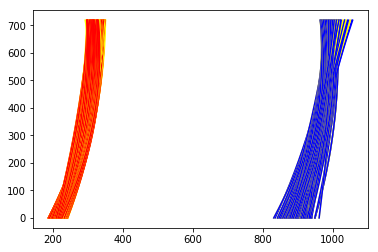

In [98]:
left_line = Line()
right_line = Line()
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'result_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
##clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [99]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))